# Tarea Obligatoria
Utilizar una librería para calcular las componentes principales e interpretar la PC1 (gráfica y teóricamente).

*Usar el dataset de paises de Europa.*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
df = pd.read_csv("../data/europe.csv")
df = df.set_index("Country")
df.head()

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
Country,,,,,,,
Austria,83871,41600,3.5,79.91,0.80,0.03,4.2
Belgium,30528,37800,3.5,79.65,1.30,0.06,7.2
Bulgaria,110879,13800,4.2,73.84,2.60,-0.80,9.6
Croatia,56594,18000,2.3,75.99,2.39,-0.09,17.7
Czech Republic,78867,27100,1.9,77.38,1.15,-0.13,8.5


# Exploración de los datos

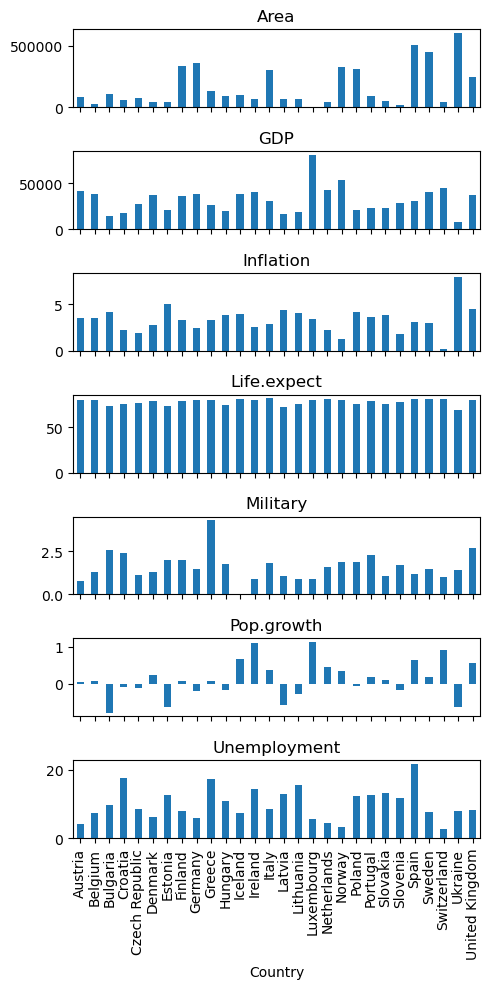

In [3]:
fig, ax = plt.subplots(len(df.columns), 1, sharex=True, figsize=(5,10))

for i, c in enumerate(df.columns):
    df[c].plot(kind="bar", ax=ax[i], title=c)

plt.tight_layout()
plt.show()

## Box Plot

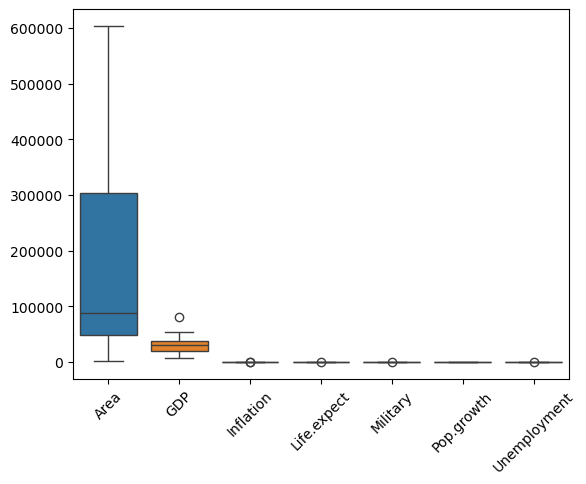

In [4]:
sns.boxplot(df)
plt.xticks(rotation=45)
plt.show()

# Scikit - Learn

## Escalado del conjunto de datos

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(df)

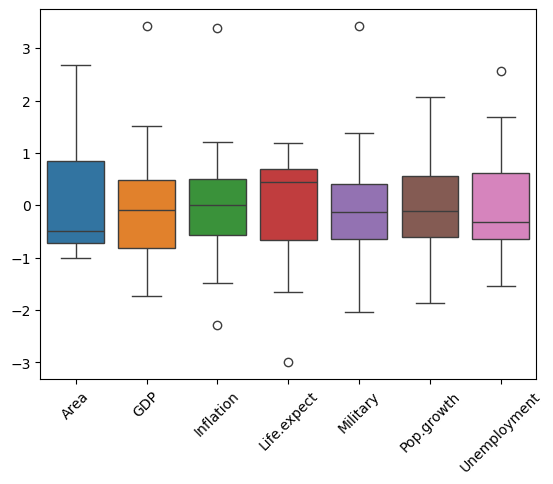

In [6]:
scaled_df = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)
sns.boxplot(scaled_df)
plt.xticks(rotation=45)
plt.show()

## Varianza explicada

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(df.columns))
pca.fit(x_scaled)

PCA(n_components=7)

Observamos que graficando los dos primeros componentes principales, podemos explicar más del 60 % de la variabilidad del conjunto de datos.

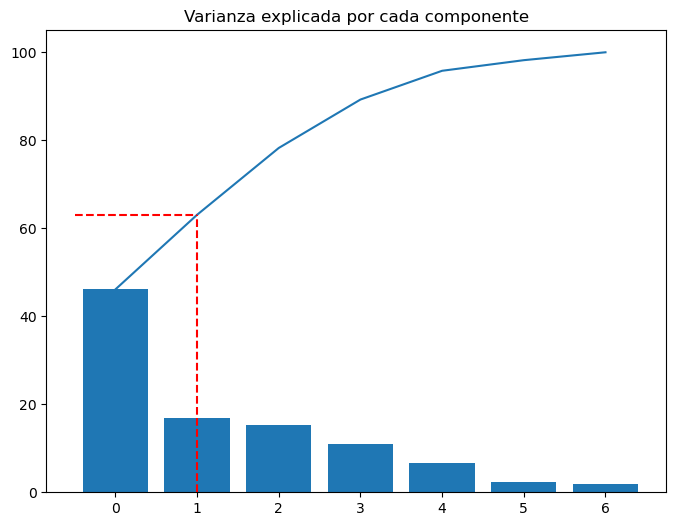

In [8]:
fig, ax = plt.subplots(1, figsize=(8, 6))

componentes = np.arange(len(df.columns))
plt.plot(componentes, pca.explained_variance_ratio_.cumsum() * 100)
plt.bar(componentes, pca.explained_variance_ratio_ * 100)

comp_dos = pca.explained_variance_ratio_.cumsum()[1] * 100
plt.hlines(comp_dos, -0.5, 1, linestyles="dashed", color="red")
plt.vlines(1, 0 , comp_dos, linestyles="dashed", color="red")

plt.title("Varianza explicada por cada componente")
plt.show()


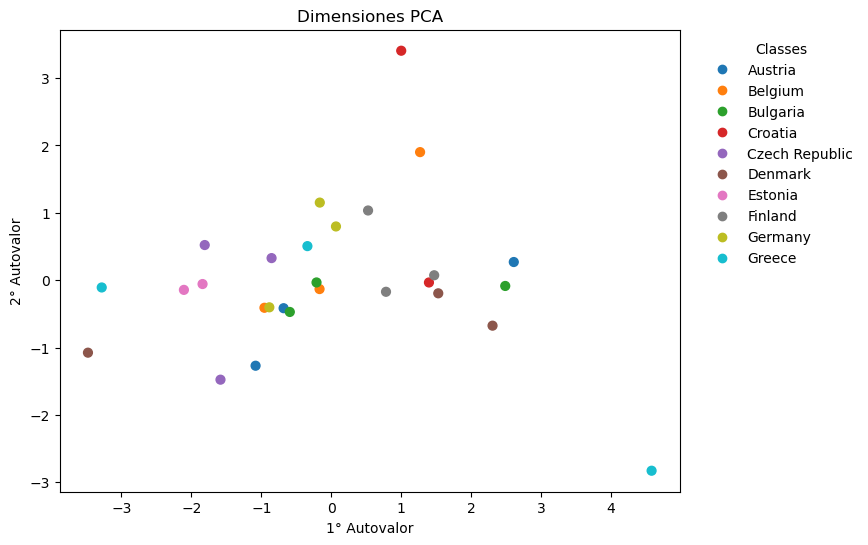

In [9]:
fig, ax = plt.subplots(1, figsize=(8, 6))

country_to_id = {country: i for i, country in enumerate(df.index)}
country_ids = [country_to_id[country] for country in df.index]

X_reduced = pca.fit_transform(x_scaled)
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=country_ids,
    s=40,
    cmap="tab10",
)

ax.set(
    title="Dimensiones PCA",
    xlabel="1° Autovalor",
    ylabel="2° Autovalor",
)

# Add a legend
legend1 = ax.legend(
    scatter.legend_elements()[0],
    df.index.tolist(),
    loc="upper right",
    title="Classes",
    bbox_to_anchor=(1.3, 1),
    frameon=False
)

plt.show()

In [10]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=["PC{}".format(i+1) for i, _ in enumerate(pca.components_)]
)
loadings.T

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
PC1,0.124874,-0.500506,0.406518,-0.482873,0.188112,-0.475704,0.271656
PC2,-0.172872,-0.130140,-0.369657,0.265248,0.658267,0.082622,0.553204
PC3,0.898297,0.083956,0.198195,0.246082,0.243679,0.163697,0.000500
PC4,0.044850,-0.084255,0.164686,0.026771,-0.562375,0.392463,0.701968
PC5,-0.324017,0.390632,0.689501,-0.101787,0.368148,0.347868,0.010159
PC6,0.190118,0.638657,-0.323867,-0.606434,0.035596,-0.120856,0.259705
PC7,0.066643,-0.397408,-0.226700,-0.507031,0.137310,0.671147,-0.244662


## Cluster sobre componentes principales

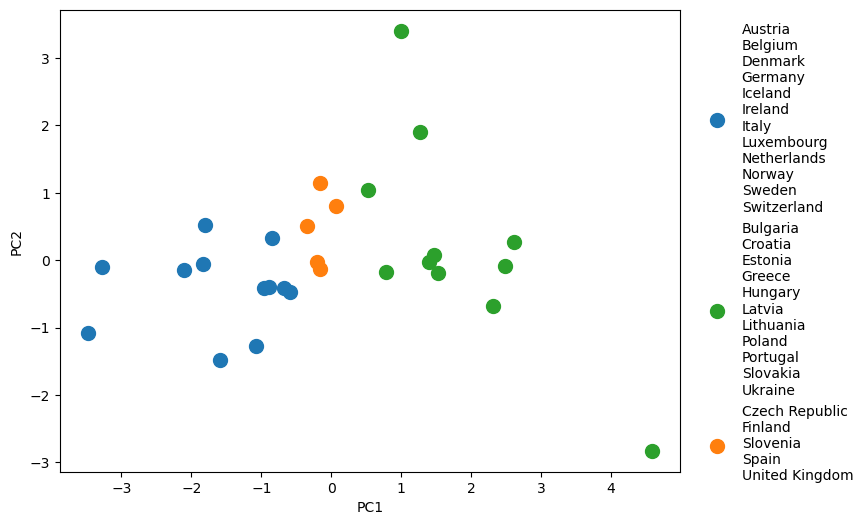

In [11]:
import sys; sys.path.append("..")
from src.kohonen import Kohonen
#from sklearn_som.som import SOM

def kohonen(x):
    #som = SOM(m=2, n=2, dim=7)
    #som.fit(x, epochs=100)
    #return som.predict(x)

    dims_out = (3, 1)
    som = Kohonen(7, dims_out)
    som.train(x, epochs=100, decay=True, shuffle=False)
    pred = som.predict(x)
    pred = [np.ravel_multi_index(p, dims_out) for p in pred]
    return pred
    
X_reduced = pca.fit_transform(x_scaled)

df["PC1"] = X_reduced[:, 0]
df["PC2"] = X_reduced[:, 1]

predictions = kohonen(X_reduced)
df["predictions"] = predictions


fig, ax = plt.subplots(1, figsize=(8, 6))
for i, pred in enumerate(df.predictions.unique()):
    tmp = df[df.predictions == pred]
    tmp.plot.scatter("PC1", "PC2", color=plt.cm.tab10(pred), colorbar=False, ax=ax, s=100, label="\n".join(tmp.index))

plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()

Se pueden asociar datos de mejor manera que si los hicieramos visualmente.

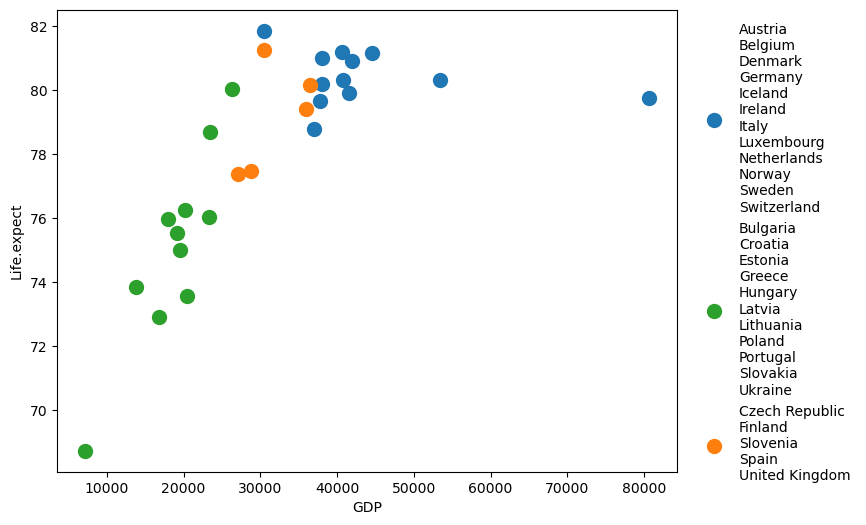

In [12]:
fig, ax = plt.subplots(1, figsize=(8, 6))
for i, pred in enumerate(df.predictions.unique()):
    tmp = df[df.predictions == pred]
    tmp.plot.scatter("GDP", "Life.expect", color=plt.cm.tab10(pred), colorbar=False, ax=ax, s=100, label="\n".join(tmp.index))
plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()

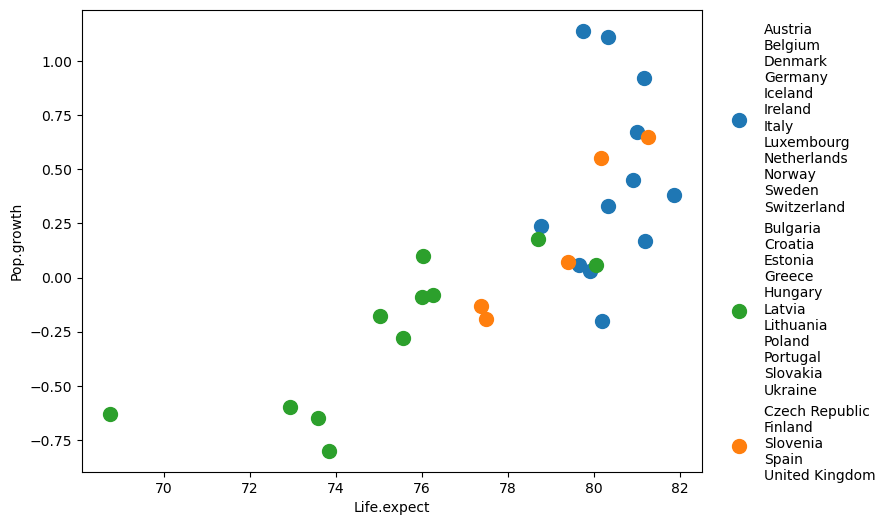

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 6))
for i, pred in enumerate(df.predictions.unique()):
    tmp = df[df.predictions == pred]
    tmp.plot.scatter("Life.expect", "Pop.growth", color=plt.cm.tab10(pred), colorbar=False, ax=ax, s=100, label="\n".join(tmp.index))
plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()

# Librería PCA

In [14]:
from pca import pca
data = pd.read_csv("../data/europe.csv")
data = data.set_index("Country")
data.head()

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
Country,,,,,,,
Austria,83871,41600,3.5,79.91,0.80,0.03,4.2
Belgium,30528,37800,3.5,79.65,1.30,0.06,7.2
Bulgaria,110879,13800,4.2,73.84,2.60,-0.80,9.6
Croatia,56594,18000,2.3,75.99,2.39,-0.09,17.7
Czech Republic,78867,27100,1.9,77.38,1.15,-0.13,8.5


## Efecto del normalizado

Al normalizar el dataset todas las variables tienen el mismo rango de unidades con $\bar{x} = 0$ y $std(x) = 1$, lo cual las mismas pueden ser comparables eviando que una variable **predomine** sobre la otra.

In [15]:
model_scaled   = pca(normalize=True)
model_unscaled = pca(normalize=False)

results_scaled   =   model_scaled.fit_transform(data.values, col_labels=data.columns, row_labels=data.index);
results_unscaled = model_unscaled.fit_transform(data.values, col_labels=data.columns, row_labels=data.index);

[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [7] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [7] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [7] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [1] that covers the [95.00%] explained variance.


In [16]:
pd.concat((
    results_scaled["topfeat"].rename(lambda x: x + "_scaled", axis=1),
    results_unscaled["topfeat"].rename(lambda x: x + "_unscaled", axis=1)
), axis=1)

,PC_scaled,feature_scaled,loading_scaled,type_scaled,PC_unscaled,feature_unscaled,loading_unscaled,type_unscaled
0,PC1,GDP,-0.500506,best,PC1,Area,9.999253e-01,best
1,PC2,Military,0.658267,best,PC1,GDP,-1.222597e-02,weak
2,PC3,Area,0.898297,best,PC1,Inflation,2.707565e-06,weak
3,PC4,Unemployment,0.701968,best,PC1,Life.expect,-4.318611e-07,weak
4,PC5,Inflation,0.689501,best,PC1,Military,4.936399e-07,weak
5,PC1,Life.expect,-0.482873,weak,PC1,Pop.growth,-2.711353e-07,weak
6,PC1,Pop.growth,-0.475704,weak,PC1,Unemployment,7.349659e-07,weak


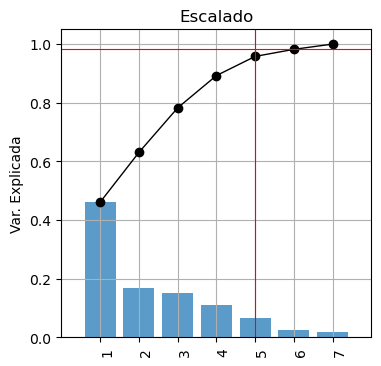

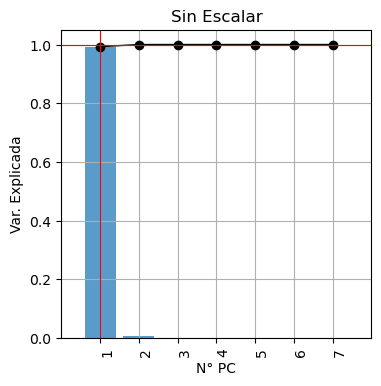

In [17]:
fig, ax = model_scaled.plot(figsize=(4,4))
ax.set_title("Escalado")
ax.set_xlabel("")
ax.set_ylabel("Var. Explicada")

fig, ax = model_unscaled.plot(figsize=(4,4))
ax.set_title("Sin Escalar")
ax.set_xlabel("N° PC")
ax.set_ylabel("Var. Explicada")

plt.show()

## BiPlot
* Nos permite identificar cuales son los features con más varianza. 
* `n_feat` nos permite elegir cuantos loading mostrar. Los colores azules son loadings debiles.
* Las flechas nos indican las direcciones de mayor varianza (los más importantes tienden a ser ortogonales)

[22-05-2025 12:37:33] [scatterd.scatterd] [INFO] Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


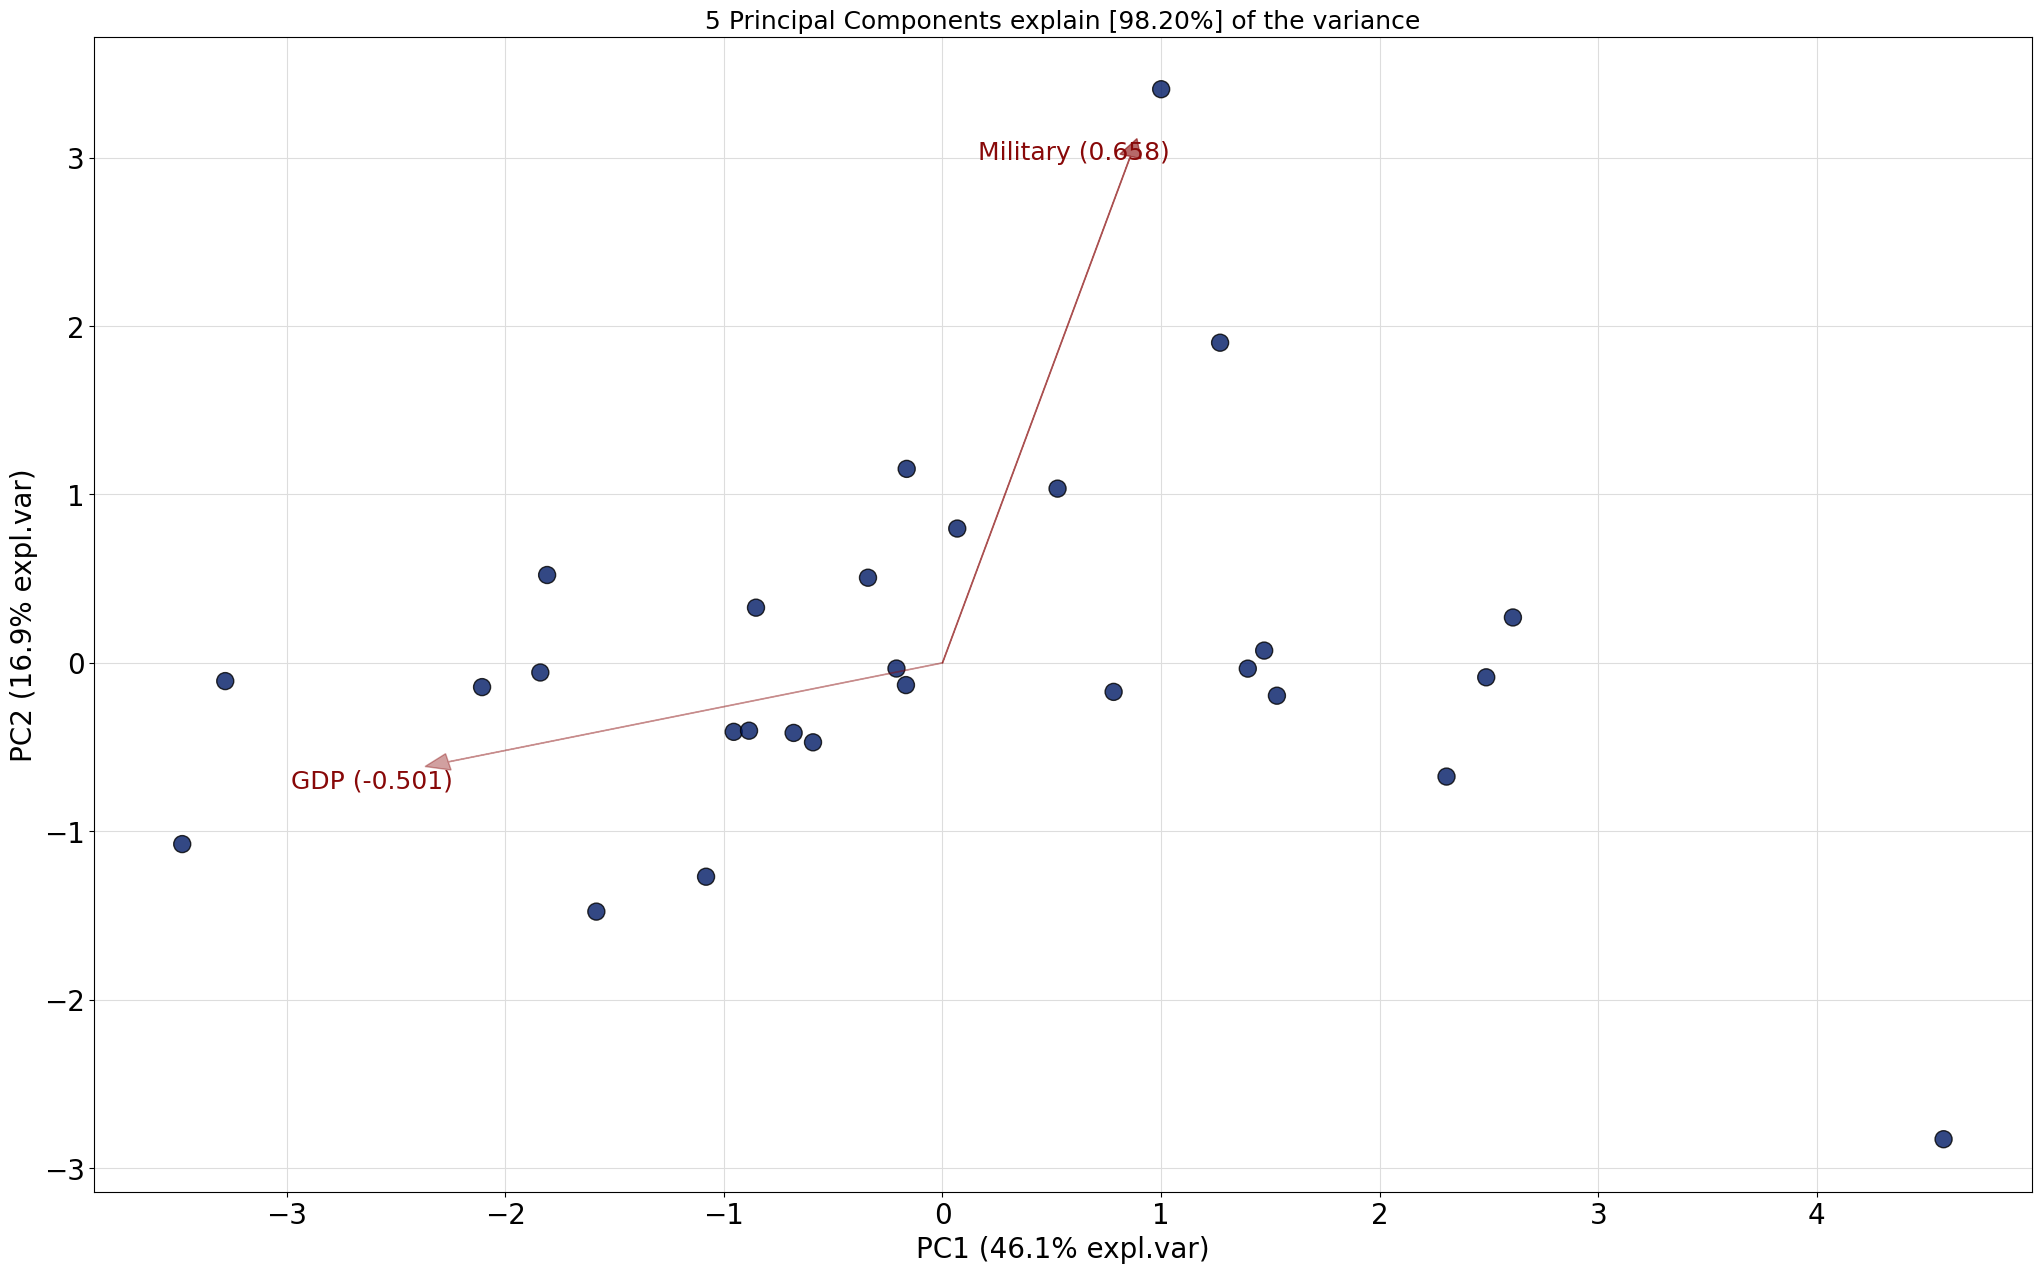

,PC,feature,loading,type
0,PC1,GDP,-0.500506,best
1,PC2,Military,0.658267,best
2,PC3,Area,0.898297,best
3,PC4,Unemployment,0.701968,best
4,PC5,Inflation,0.689501,best
5,PC1,Life.expect,-0.482873,weak
6,PC1,Pop.growth,-0.475704,weak


In [18]:
model = model_scaled
fig, ax = model.biplot(n_feat=2, PC=[0, 1])
plt.show()
results_scaled["topfeat"]

In [19]:
# Las flechas son las proyecciones de los versores de las columnas sobre las componentes principales
results_scaled["loadings"]

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
PC1,0.124874,-0.500506,0.406518,-0.482873,0.188112,-0.475704,0.271656
PC2,-0.172872,-0.130140,-0.369657,0.265248,0.658267,0.082622,0.553204
PC3,0.898297,0.083956,0.198195,0.246082,0.243679,0.163697,0.000500
PC4,0.044850,-0.084255,0.164686,0.026771,-0.562375,0.392463,0.701968
PC5,-0.324017,0.390632,0.689501,-0.101787,0.368148,0.347868,0.010159


[22-05-2025 12:37:33] [scatterd.scatterd] [INFO] Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


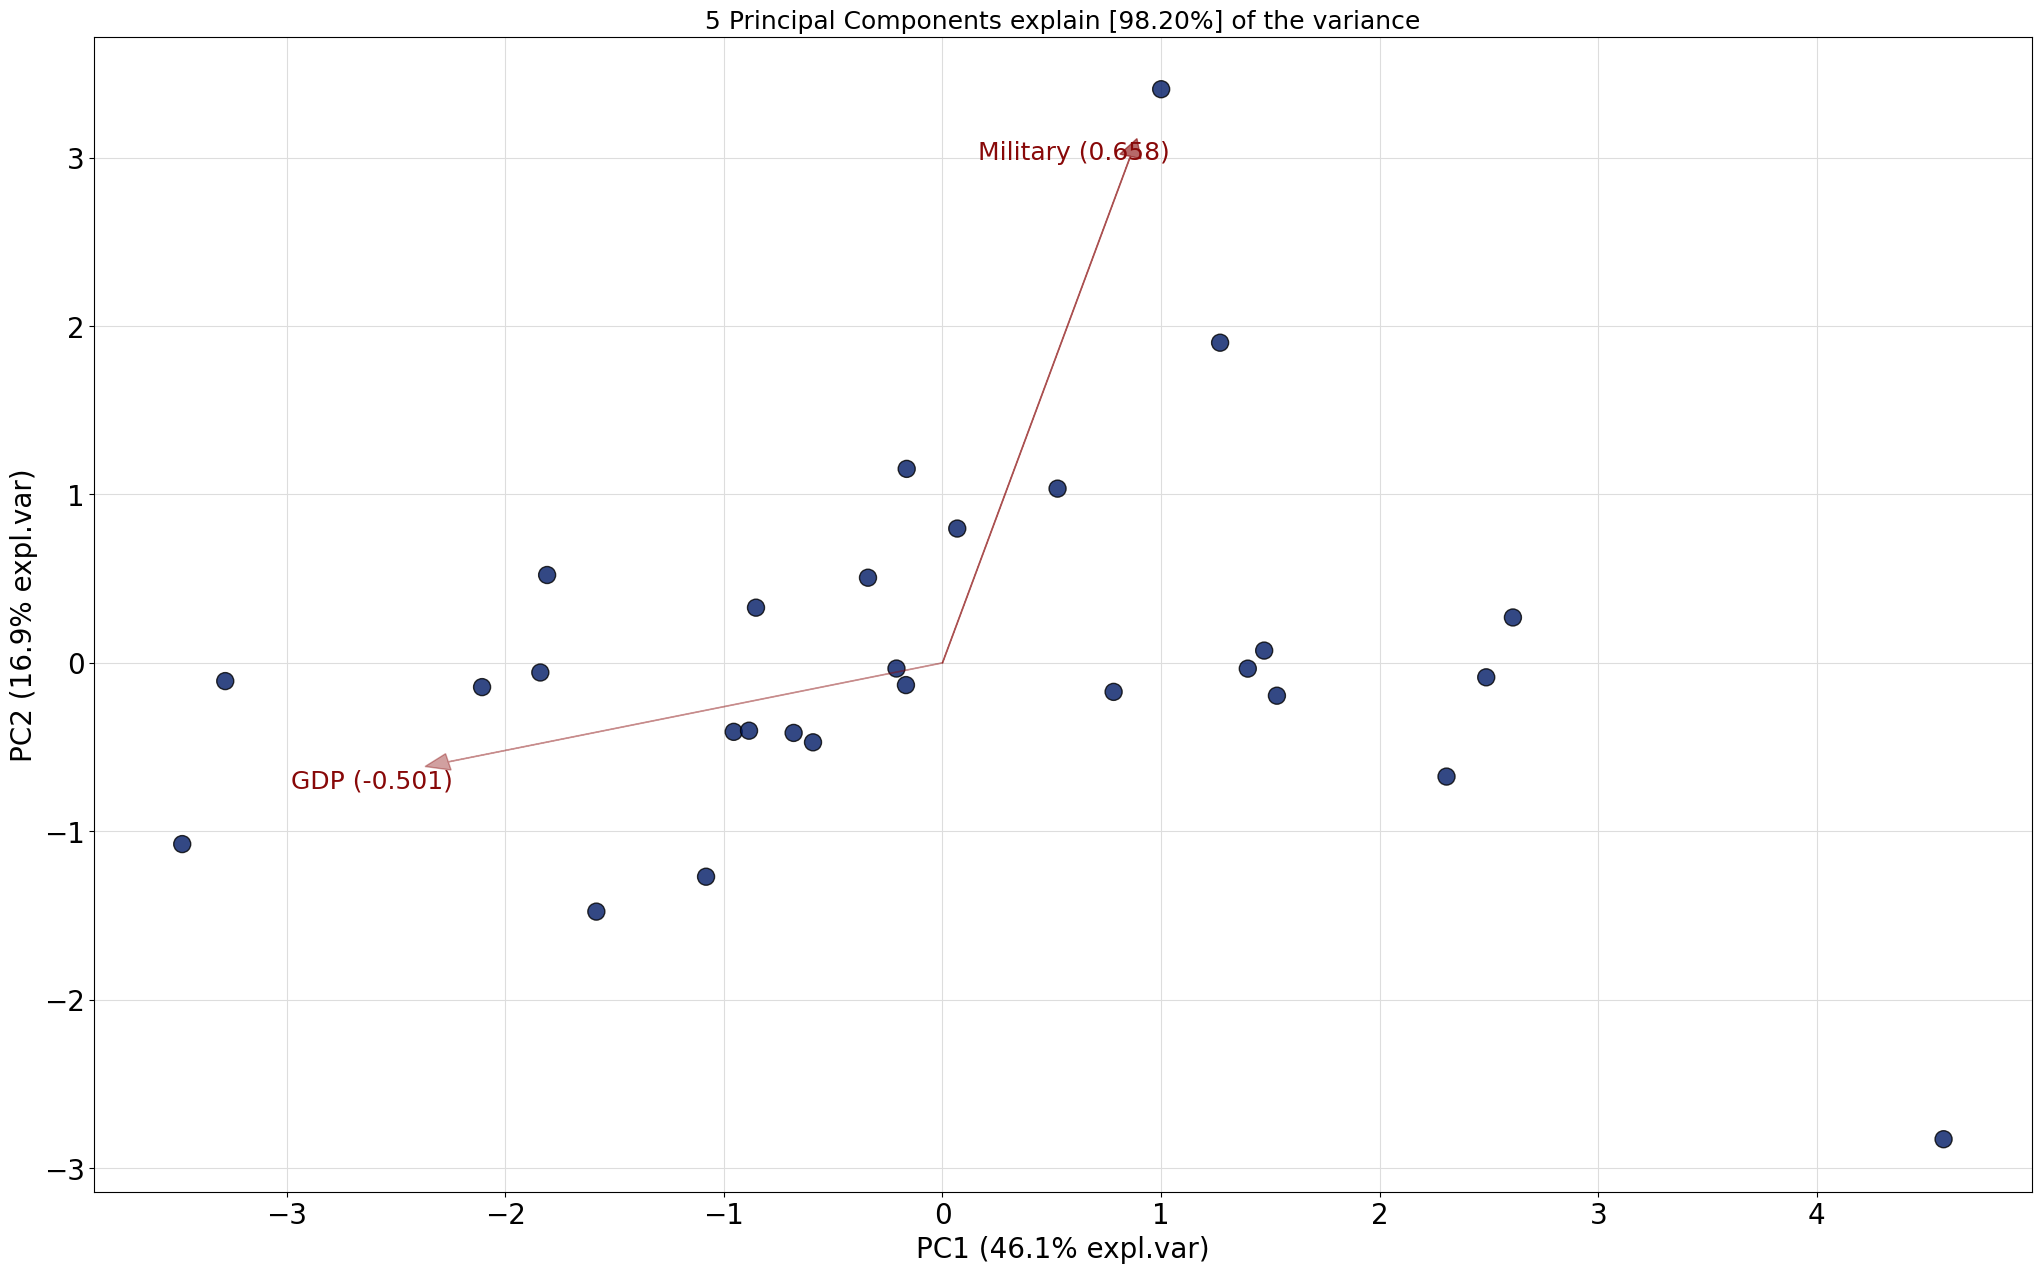

,PC,feature,loading,type
0,PC1,GDP,-0.500506,best
1,PC2,Military,0.658267,best
2,PC3,Area,0.898297,best
3,PC4,Unemployment,0.701968,best
4,PC5,Inflation,0.689501,best
5,PC1,Life.expect,-0.482873,weak
6,PC1,Pop.growth,-0.475704,weak


In [20]:
model = model_scaled
fig, ax = model.biplot(n_feat=2, PC=[0, 1])
plt.show()
results_scaled["topfeat"]

In [21]:
# Para el caso del GDP sobre el grafico anterior
ans = results_scaled["loadings"] @ np.array([0, 1, 0, 0, 0, 0, 0])
# factor de escala es 4.5 en el grafico - a fines graficos
ans.iloc[:2] * 4.5

PC1   -2.252276
PC2   -0.585628
dtype: float64

[22-05-2025 12:37:33] [scatterd.scatterd] [INFO] Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


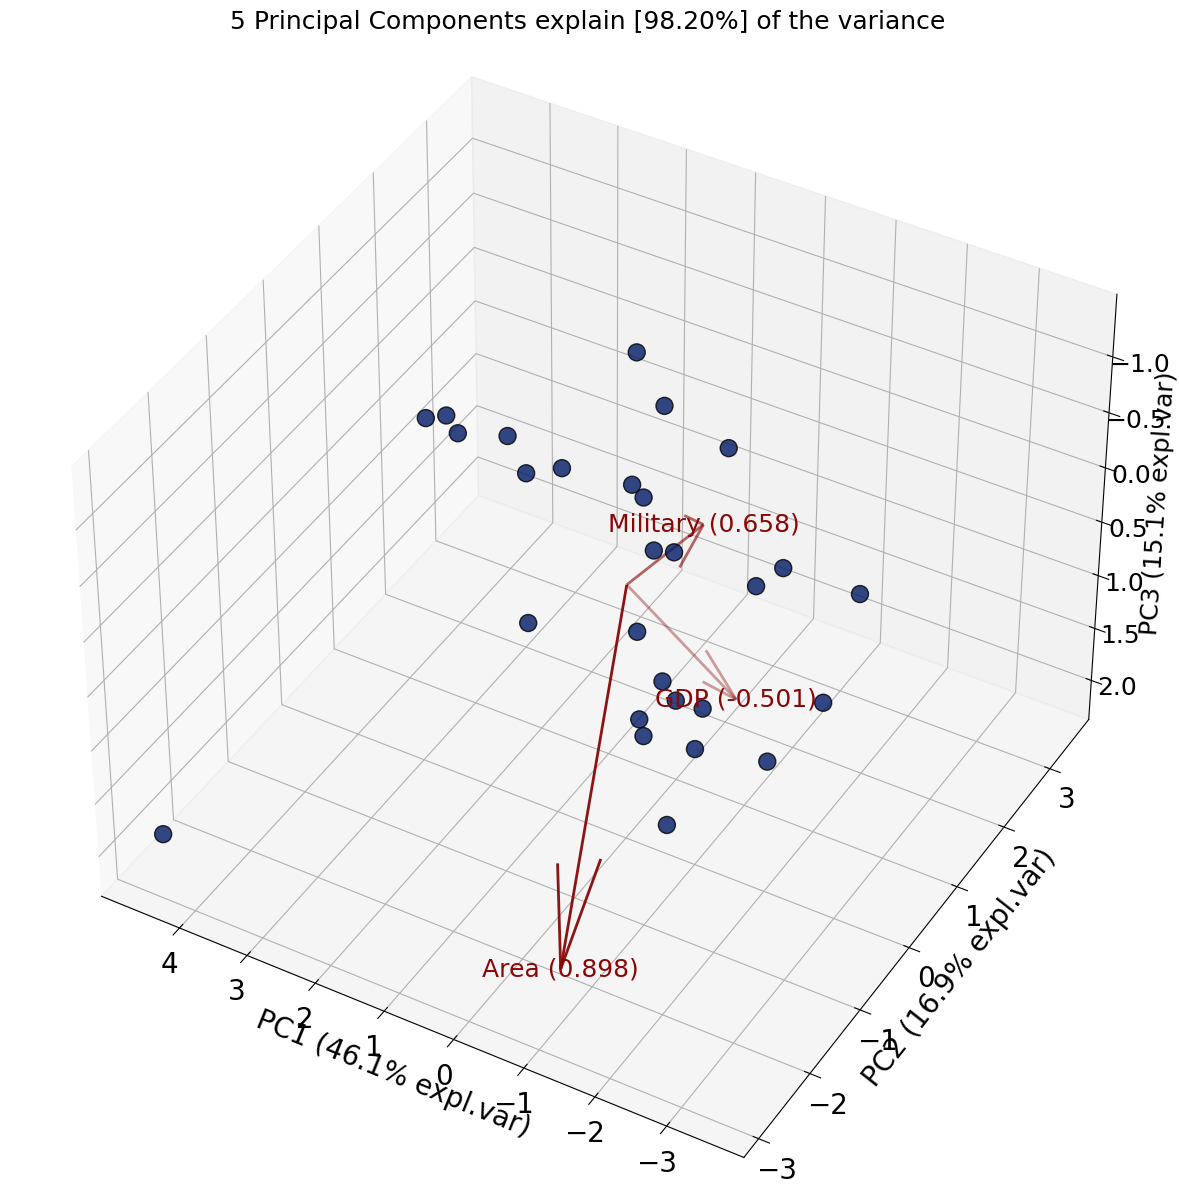

In [22]:
model = model_scaled
fig, ax = model.biplot(n_feat=3, PC=[0, 1, 2])
plt.show()